### NLP challenge

# Clasificador de Décadas de Textos - Pipeline Completo

Este notebook implementa un sistema de clasificación para predecir la década en que fueron escritos textos históricos, utilizando únicamente técnicas clásicas de Machine Learning y PLN.

# 1. Importación de Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import unicodedata
import string
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, f1_score, precision_score, recall_score)

import joblib

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas correctamente")

Librerías importadas correctamente


# 2. Carga de Datos

In [ ]:
print("Cargando datasets...")

df_train = pd.read_csv("train.csv")
print(f"Train: {df_train.shape[0]:,} filas, {df_train.shape[1]} columnas")

df_eval = pd.read_csv("eval.csv")
print(f"Eval: {df_eval.shape[0]:,} filas, {df_eval.shape[1]} columnas")

print("\nPrimeras filas del dataset de entrenamiento:")
display(df_train.head())

print("\nPrimeras filas del dataset de evaluación:")
display(df_eval.head())

Cargando datasets...
Train: 31,403 filas, 2 columnas
Eval: 3,490 filas, 2 columnas

Primeras filas del dataset de entrenamiento:


,text,decade
0,\nHonorarias ¡jubiladas. 57 \ndit.ad Pontem de...,164
1,"gone. Sus amigos , sus clientes, todo \ncuanto...",182
2,"Prefosen quemanera,e per qualesfolpechas deuan...",157
3,Caistro el M a y o r a i .] Del ape...,163
4,\nlos que panden macho ; y \notros en l...,166



Primeras filas del dataset de evaluación:


,id,text
0,0,P. Si en efta convocación trato folament...
1,1,«Muy santo Padre : Ayer escribiá don Juan Man-...
2,2,"Recibo, otorgado por Diego Gracián a favor de ..."
3,3,6. Los Samaritanos no admitían por \nEfcr...
4,4,ü«mi yofacaremisoiiejasfilasmaí \nI nosodlosr...


# 3. Análisis Exploratorio de Datos (EDA)

In [ ]:
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*50)

print("Información general del dataset:")
print(f"Dimensiones: {df_train.shape}")
print(f"Tipos de datos:")
print(df_train.dtypes)

ANÁLISIS EXPLORATORIO DE DATOS
Información general del dataset:
• Dimensiones: (31403, 2)
• Tipos de datos:
text      object
decade     int64
dtype: object


## 3.1 Distribución de Décadas


DISTRIBUCIÓN DE DÉCADAS
------------------------------
Distribución por década:
decade
150    786
151    812
152    785
153    775
154    830
155    836
156    792
157    827
158    778
159    802
160    848
161    787
162    808
163    827
164    804
165    814
166    779
167    831
168    822
169    771
170    833
171    816
172    842
173    802
174    807
175    817
176    754
177    782
178    831
179    809
180    825
181    795
182    808
183    794
184    802
185    803
186    773
187    787
188    809
Name: count, dtype: int64


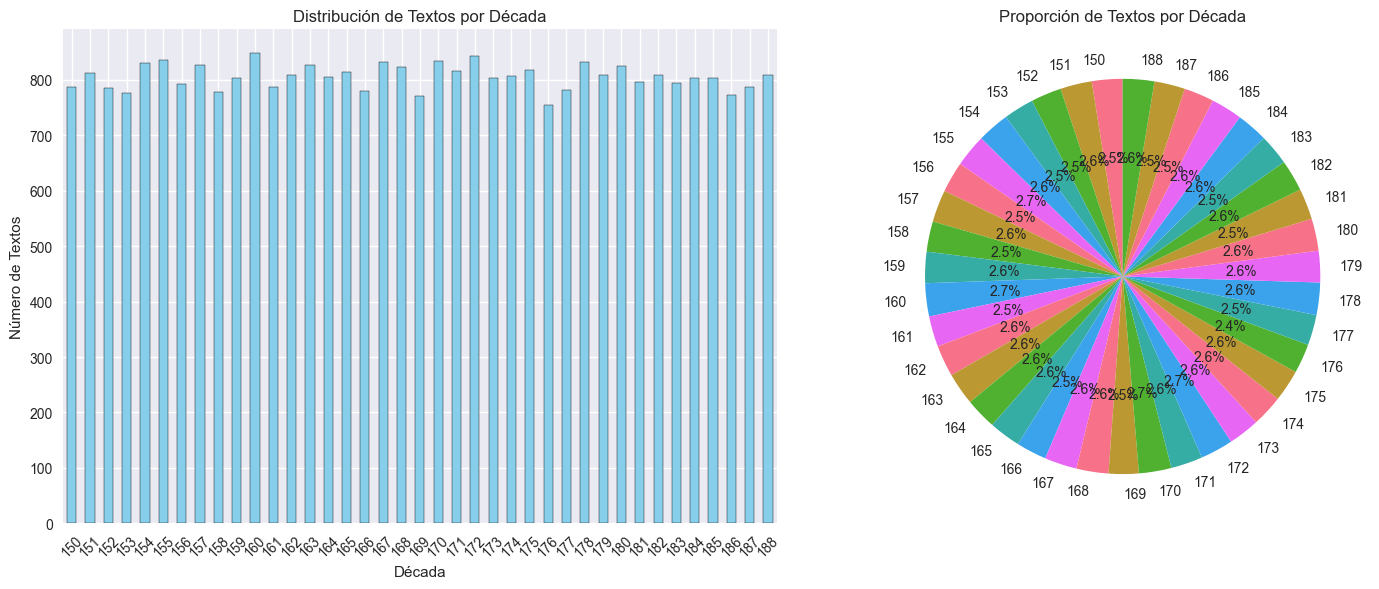


Análisis de balanceamiento:
• Década más común: 160 (848 textos)
• Década menos común: 176 (754 textos)
• Ratio desbalance: 1.12:1


In [ ]:
print("\nDISTRIBUCIÓN DE DÉCADAS")
print("-" * 30)

decade_counts = df_train['decade'].value_counts().sort_index()
print("Distribución por década:")
print(decade_counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

decade_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribución de Textos por Década')
ax1.set_xlabel('Década')
ax1.set_ylabel('Número de Textos')
ax1.tick_params(axis='x', rotation=45)

ax2.pie(decade_counts.values, labels=decade_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Proporción de Textos por Década')

plt.tight_layout()
plt.show()

print(f"\nAnálisis de balanceamiento:")
print(f"Década más común: {decade_counts.idxmax()} ({decade_counts.max():,} textos)")
print(f"Década menos común: {decade_counts.idxmin()} ({decade_counts.min():,} textos)")
print(f"Ratio desbalance: {decade_counts.max() / decade_counts.min():.2f}:1")

# 3.2 Análisis de Texto


ANÁLISIS DE CARACTERÍSTICAS DE TEXTO
----------------------------------------
Estadísticas generales de texto:
        text_length   word_count  sentence_count
count  31403.000000  31403.00000    31403.000000
mean     520.568290     82.28319        5.675127
std      530.947792     82.37419        7.041276
min      120.000000      3.00000        1.000000
25%      182.000000     30.00000        2.000000
50%      315.000000     50.00000        4.000000
75%      643.000000    102.00000        7.000000
max     7418.000000   1146.00000      197.000000


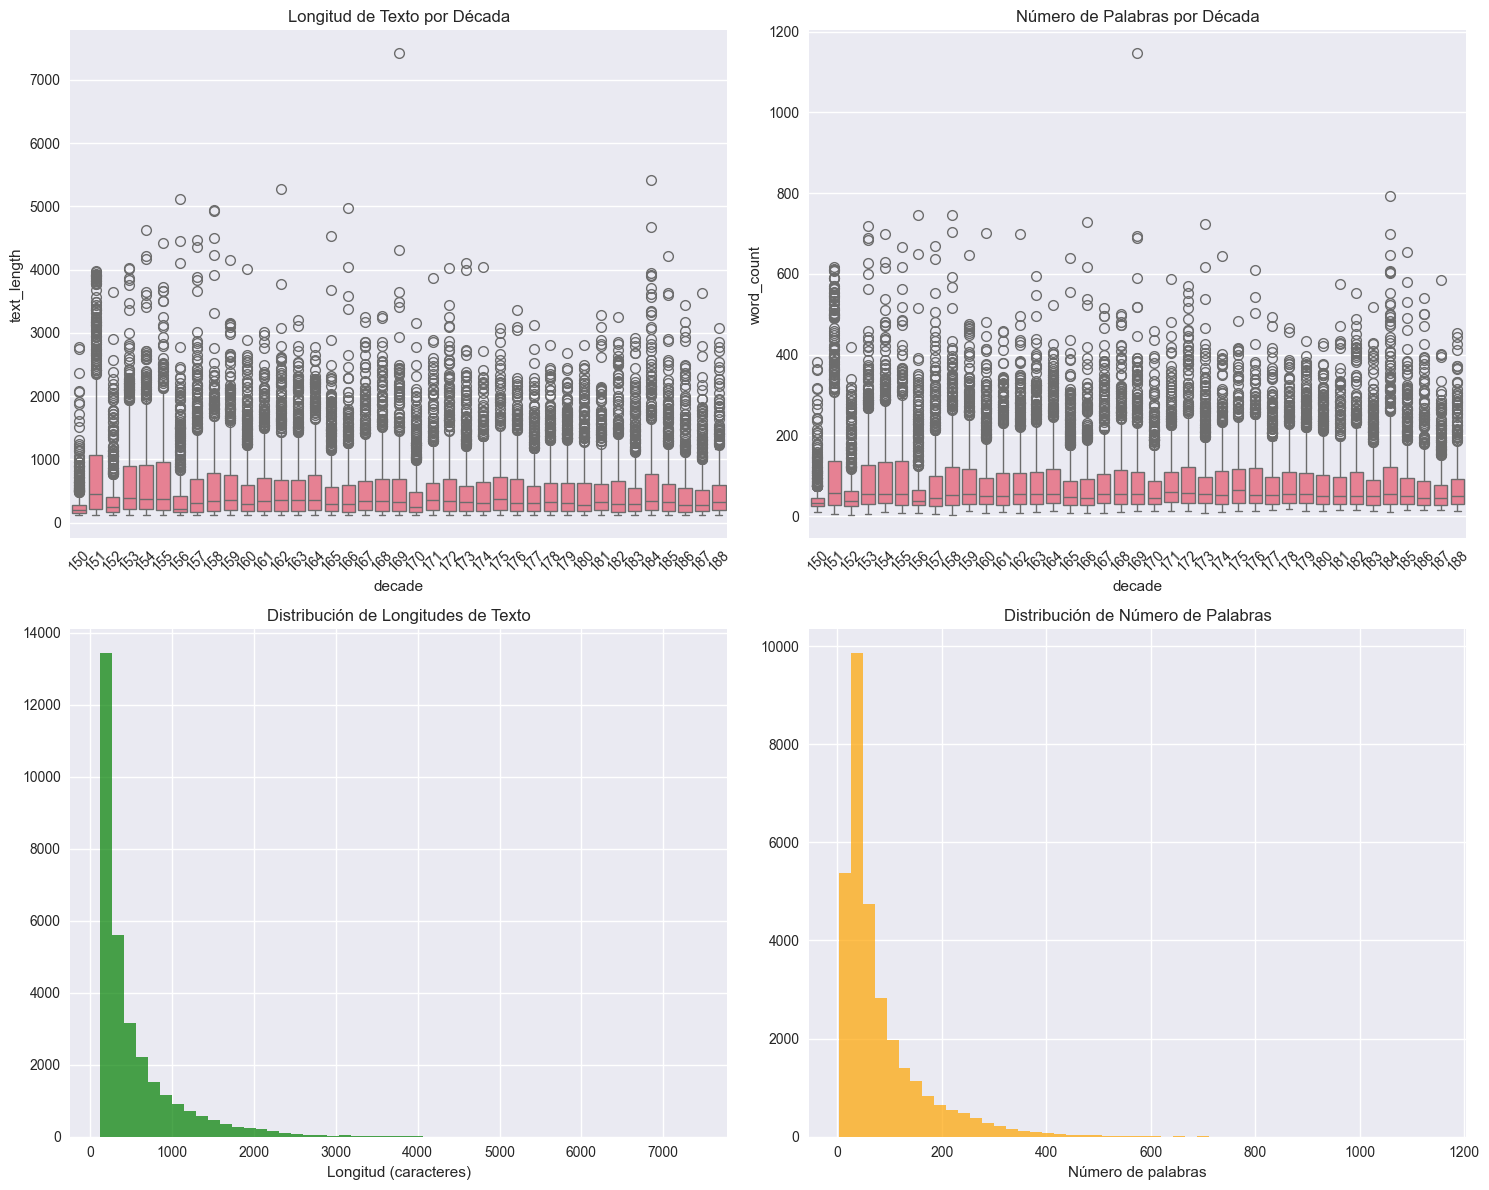

In [6]:
print("\nANÁLISIS DE CARACTERÍSTICAS DE TEXTO")
print("-" * 40)

df_train['text_length'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().str.len()
df_train['sentence_count'] = df_train['text'].str.split('.').str.len()

print("Estadísticas generales de texto:")
text_stats = df_train[['text_length', 'word_count', 'sentence_count']].describe()
print(text_stats)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.boxplot(data=df_train, x='decade', y='text_length', ax=axes[0,0])
axes[0,0].set_title('Longitud de Texto por Década')
axes[0,0].tick_params(axis='x', rotation=45)

# Número de palabras por década
sns.boxplot(data=df_train, x='decade', y='word_count', ax=axes[0,1])
axes[0,1].set_title('Número de Palabras por Década')
axes[0,1].tick_params(axis='x', rotation=45)

df_train['text_length'].hist(bins=50, ax=axes[1,0], alpha=0.7, color='green')
axes[1,0].set_title('Distribución de Longitudes de Texto')
axes[1,0].set_xlabel('Longitud (caracteres)')

df_train['word_count'].hist(bins=50, ax=axes[1,1], alpha=0.7, color='orange')
axes[1,1].set_title('Distribución de Número de Palabras')
axes[1,1].set_xlabel('Número de palabras')

plt.tight_layout()
plt.show()

# 4. Calidad y Limpieza de Datos

In [ ]:
print("ANÁLISIS DE CALIDAD DE DATOS")
print("="*40)

print("Valores nulos:")
null_counts = df_train.isnull().sum()
print(null_counts)

print(f"\nDuplicados:")
duplicates = df_train.duplicated().sum()
print(f"Filas duplicadas: {duplicates}")

if duplicates > 0:
    print("Mostrando duplicados:")
    display(df_train[df_train.duplicated()])

print(f"\nAnálisis de textos problemáticos:")
empty_texts = df_train['text'].str.strip().eq('').sum()
very_short = (df_train['text'].str.len() < 10).sum()
print(f"Textos vacíos: {empty_texts}")
print(f"Textos muy cortos (<10 caracteres): {very_short}")

print(f"\nLimpiando datos...")
df_clean = df_train.copy()

df_clean = df_clean.dropna(subset=['text', 'decade']).reset_index(drop=True)

df_clean = df_clean.drop_duplicates().reset_index(drop=True)

df_clean = df_clean[df_clean['text'].str.len() >= 10].reset_index(drop=True)

print(f"Datos limpios:")
print(f"Filas originales: {len(df_train):,}")
print(f"Filas después de limpieza: {len(df_clean):,}")
print(f"Filas eliminadas: {len(df_train) - len(df_clean):,}")

ANÁLISIS DE CALIDAD DE DATOS
Valores nulos:
text              0
decade            0
text_length       0
word_count        0
sentence_count    0
dtype: int64

Duplicados:
• Filas duplicadas: 34
Mostrando duplicados:


,text,decade,text_length,word_count,sentence_count
5954,fer pinero oífcipulo.nccdTarío es qavas fiooob...,151,1478,210,19
7007,III ifi crgo prxtcimitci íiullaitnUs voio...,161,421,43,5
13700,"DEMEDICINALI MATERIA \nainjmecapitulum,mquofem...",151,176,5,4
14580,d ¶Salueſe.no.ex hac.l.iureiurando innocentiam...,153,255,29,23
17034,\naudiencias. Podrá realizar búsquedas en el t...,153,123,18,4
17704,+ Añiado;que fi en laforima- \ncion del bezerr...,166,418,70,2
17882,"\nfegntemill exentos, 3 \ncin ElfeclFal ole, d...",150,314,37,9
18146,cuf o paoreauía furo grácifluno amigo. jEraoe ...,151,593,90,5
18488,búdorpudieííepagara los que tuuieílén libra...,155,373,57,3
18673,"\nEarly European Books, Copyright© 201 1 ...",158,138,18,3



Análisis de textos problemáticos:
• Textos vacíos: 0
• Textos muy cortos (<10 caracteres): 0

Limpiando datos...
Datos limpios:
Filas originales: 31,403
Filas después de limpieza: 31,369
Filas eliminadas: 34


# 5. Feature Engineering

In [8]:
print("FEATURE ENGINEERING")
print("="*30)

def extract_text_features(text):
    """
    Extrae características avanzadas de un texto.
    """
    if pd.isna(text) or text.strip() == '':
        return {}
    
    features = {}
    
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = len([s for s in text.split('.') if s.strip()])
    features['avg_word_length'] = np.mean([len(word) for word in text.split()]) if text.split() else 0
    
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['comma_count'] = text.count(',')
    features['semicolon_count'] = text.count(';')
    features['colon_count'] = text.count(':')
    
    features['capital_ratio'] = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    features['title_words'] = sum(1 for word in text.split() if word.istitle()) / len(text.split()) if text.split() else 0
    
    features['digit_ratio'] = sum(1 for c in text if c.isdigit()) / len(text) if text else 0
    
    latin_indicators = ['et', 'de', 'in', 'ad', 'ex', 'cum', 'per', 'pro', 'ab', 'ob']
    features['latin_words'] = sum(1 for word in text.lower().split() if word in latin_indicators)
    
    return features

print("Extrayendo características...")
feature_dicts = df_clean['text'].apply(extract_text_features)
feature_df = pd.DataFrame(feature_dicts.tolist())

df_features = pd.concat([df_clean[['text', 'decade']], feature_df], axis=1)

print(f"Features extraídas: {feature_df.shape[1]} características")
print("\nNuevas características:")
print(feature_df.columns.tolist())

print(f"\nEstadísticas de las nuevas características:")
display(feature_df.describe())

FEATURE ENGINEERING
Extrayendo características...
Features extraídas: 13 características

Nuevas características:
['char_count', 'word_count', 'sentence_count', 'avg_word_length', 'exclamation_count', 'question_count', 'comma_count', 'semicolon_count', 'colon_count', 'capital_ratio', 'title_words', 'digit_ratio', 'latin_words']

Estadísticas de las nuevas características:


,char_count,word_count,sentence_count,avg_word_length,exclamation_count,question_count,comma_count,semicolon_count,colon_count,capital_ratio,title_words,digit_ratio,latin_words
count,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000,31369.000000
mean,520.593420,82.294526,5.148777,4.886451,0.156779,0.302145,6.872135,0.580127,1.168861,0.032190,0.122610,0.007347,3.894131
std,531.017856,82.381783,6.863664,1.307212,0.538464,1.219296,8.374359,1.167916,2.914910,0.038989,0.096463,0.017503,4.855996
min,120.000000,3.000000,1.000000,1.098592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,182.000000,30.000000,2.000000,4.280000,0.000000,0.000000,2.000000,0.000000,0.000000,0.013072,0.052632,0.000000,1.000000
50%,315.000000,50.000000,3.000000,4.663551,0.000000,0.000000,4.000000,0.000000,0.000000,0.023158,0.100000,0.001672,2.000000
75%,643.000000,102.000000,6.000000,5.173913,0.000000,0.000000,9.000000,1.000000,1.000000,0.038462,0.166667,0.007833,5.000000
max,7418.000000,1146.000000,191.000000,54.333333,12.000000,41.000000,139.000000,23.000000,70.000000,0.808989,1.000000,0.771654,102.000000


# 6. Preprocesamiento de Texto

In [9]:
print("PREPROCESAMIENTO DE TEXTO")
print("="*35)

def advanced_clean_text(text):
    """
    Función avanzada de limpieza de texto para textos históricos.
    """
    if pd.isna(text):
        return ""
    
    text = unicodedata.normalize("NFKC", str(text))
    
    text = text.lower()
    
    text = re.sub(r'[^\w\s\.\,\;\:\!\?\-]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = text.strip()
    
    return text

print("Aplicando preprocesamiento...")
df_features['text_clean'] = df_features['text'].apply(advanced_clean_text)

print("Preprocesamiento completado")
print("\nEjemplo de transformación:")
print("Original:", df_features['text'].iloc[0][:100] + "...")
print("Limpio:", df_features['text_clean'].iloc[0][:100] + "...")

PREPROCESAMIENTO DE TEXTO
Aplicando preprocesamiento...
Preprocesamiento completado

Ejemplo de transformación:
Original: 
Honorarias ¡jubiladas. 57 
dit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 
pag.4.1. 3 Ste ph.Grati...
Limpio: honorarias jubiladas. 57 dit.ad pontem de poreft.proreg.118,3, .9.m.-70 pag.4.1. 3 ste ph.gratian. d...


# 7. Split de Datos y Preparación


In [10]:
print("SPLIT DE DATOS Y PREPARACIÓN")
print("="*40)

# Preparar datos para modeling
X_text = df_features['text_clean'].values
X_features = df_features[feature_df.columns].values  # Features numéricas
y = df_features['decade'].values

print(f"Datos preparados:")
print(f"Textos: {len(X_text):,}")
print(f"Features numéricas: {X_features.shape[1]}")
print(f"Clases únicas: {len(np.unique(y))}")

# Split estratificado
X_train_text, X_test_text, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_text, X_features, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nSplit completado:")
print(f"Train: {len(X_train_text):,} ({len(X_train_text)/len(X_text)*100:.1f}%)")
print(f"Test: {len(X_test_text):,} ({len(X_test_text)/len(X_text)*100:.1f}%)")

# Verificar distribución en splits
print(f"\nDistribución mantenida:")
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()
print("Train:", dict(train_dist))
print("Test:", dict(test_dist))

SPLIT DE DATOS Y PREPARACIÓN
Datos preparados:
Textos: 31,369
Features numéricas: 13
Clases únicas: 39

Split completado:
Train: 25,095 (80.0%)
Test: 6,274 (20.0%)

Distribución mantenida:
Train: {150: 628, 151: 642, 152: 627, 153: 615, 154: 663, 155: 666, 156: 633, 157: 662, 158: 620, 159: 642, 160: 678, 161: 628, 162: 646, 163: 660, 164: 643, 165: 651, 166: 622, 167: 665, 168: 658, 169: 617, 170: 666, 171: 651, 172: 674, 173: 642, 174: 646, 175: 654, 176: 603, 177: 626, 178: 665, 179: 647, 180: 660, 181: 635, 182: 646, 183: 635, 184: 642, 185: 642, 186: 618, 187: 630, 188: 647}
Test: {150: 157, 151: 161, 152: 157, 153: 154, 154: 166, 155: 167, 156: 158, 157: 165, 158: 155, 159: 160, 160: 170, 161: 157, 162: 162, 163: 165, 164: 161, 165: 163, 166: 156, 167: 166, 168: 164, 169: 154, 170: 167, 171: 163, 172: 168, 173: 160, 174: 161, 175: 163, 176: 150, 177: 156, 178: 166, 179: 162, 180: 165, 181: 159, 182: 162, 183: 159, 184: 160, 185: 161, 186: 155, 187: 157, 188: 162}


# 8. Modelos Baseline Múltiples

In [11]:
print("ENTRENAMIENTO DE MODELOS BASELINE")
print("="*45)

word_tfidf = TfidfVectorizer(ngram_range=(1,2), analyzer='word', max_df=0.9, min_df=2, max_features=5000)
char_tfidf = TfidfVectorizer(ngram_range=(3,5), analyzer='char', max_df=0.9, min_df=2, max_features=3000)

text_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('word_tfidf', word_tfidf),
        ('char_tfidf', char_tfidf)
    ]))
])

print("Entrenando pipeline de texto...")
X_train_text_transformed = text_pipeline.fit_transform(X_train_text)
X_test_text_transformed = text_pipeline.transform(X_test_text)

from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
X_test_feat_scaled = scaler.transform(X_test_feat)

X_train_combined = hstack([X_train_text_transformed, X_train_feat_scaled])
X_test_combined = hstack([X_test_text_transformed, X_test_feat_scaled])

print(f"Features combinadas: {X_train_combined.shape[1]} dimensiones")

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', class_weight='balanced', random_state=42)
}

results = {}
print("\nEVALUACIÓN DE MODELOS:")
print("-" * 30)

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    if name == 'MultinomialNB':
        model.fit(X_train_text_transformed, y_train)
        y_pred = model.predict(X_test_text_transformed)
    else:
        model.fit(X_train_combined, y_train)
        y_pred = model.predict(X_test_combined)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'model': model
    }
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")

print(f"\nRANKING DE MODELOS:")
print("-" * 25)
sorted_results = sorted(results.items(), key=lambda x: x[1]['f1_macro'], reverse=True)
for i, (name, metrics) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: F1={metrics['f1_macro']:.4f}, Acc={metrics['accuracy']:.4f}")

ENTRENAMIENTO DE MODELOS BASELINE
Entrenando pipeline de texto...
Features combinadas: 8013 dimensiones

EVALUACIÓN DE MODELOS:
------------------------------

Entrenando LogisticRegression...
LogisticRegression:
Accuracy: 0.2282
F1-macro: 0.2235

Entrenando RandomForest...
RandomForest:
Accuracy: 0.1710
F1-macro: 0.1575

Entrenando MultinomialNB...
MultinomialNB:
Accuracy: 0.2078
F1-macro: 0.1879

Entrenando SVM...
SVM:
Accuracy: 0.2329
F1-macro: 0.2306

RANKING DE MODELOS:
-------------------------
1. SVM: F1=0.2306, Acc=0.2329
2. LogisticRegression: F1=0.2235, Acc=0.2282
3. MultinomialNB: F1=0.1879, Acc=0.2078
4. RandomForest: F1=0.1575, Acc=0.1710


# 9. Optimización del Mejor Modelo

In [12]:
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*40)

from sklearn.model_selection import GridSearchCV

best_model_name = sorted_results[0][0]
best_base_model = results[best_model_name]['model']

print(f"Optimizando: {best_model_name}")

if best_model_name == 'LogisticRegression':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'solver': ['saga', 'lbfgs'],
        'max_iter': [1000, 2000]
    }
elif best_model_name == 'RandomForest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    }

print("Ejecutando GridSearchCV...")
grid_search = GridSearchCV(
    estimator=type(best_base_model)(**best_base_model.get_params()),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

if best_model_name == 'MultinomialNB':
    grid_search.fit(X_train_text_transformed, y_train)
    X_test_final = X_test_text_transformed
else:
    grid_search.fit(X_train_combined, y_train)
    X_test_final = X_test_combined

print(f"Optimización completada!")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1-macro CV: {grid_search.best_score_:.4f}")

final_model = grid_search.best_estimator_
y_pred_final = final_model.predict(X_test_final)

print(f"\nEVALUACIÓN FINAL:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"F1-macro: {f1_score(y_test, y_pred_final, average='macro'):.4f}")

print(f"\nReporte detallado:")
print(classification_report(y_test, y_pred_final))

OPTIMIZACIÓN DE HIPERPARÁMETROS
Optimizando: SVM
Ejecutando GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Optimización completada!
Mejores parámetros: {'C': 1.0, 'kernel': 'linear'}
Mejor F1-macro CV: 0.2243

EVALUACIÓN FINAL:
Accuracy: 0.2329
F1-macro: 0.2306

Reporte detallado:
              precision    recall  f1-score   support

         150       0.78      0.71      0.74       157
         151       0.47      0.58      0.52       161
         152       0.56      0.58      0.57       157
         153       0.44      0.55      0.49       154
         154       0.41      0.44      0.43       166
         155       0.22      0.23      0.23       167
         156       0.28      0.32      0.30       158
         157       0.19      0.21      0.20       165
         158       0.19      0.20      0.19       155
         159       0.19      0.23      0.21       160
         160       0.14      0.13      0.14       170
         161       0.20      0.21      0

# 10. Predicción Final

In [ ]:
print("PREDICCIÓN EN DATASET DE EVALUACIÓN")
print("="*45)

print("Procesando datos de evaluación...")
df_eval['text_clean'] = df_eval['text'].apply(advanced_clean_text)

eval_feature_dicts = df_eval['text'].apply(extract_text_features)
eval_feature_df = pd.DataFrame(eval_feature_dicts.tolist())

X_eval_text = df_eval['text_clean'].values
X_eval_text_transformed = text_pipeline.transform(X_eval_text)

X_eval_feat_scaled = scaler.transform(eval_feature_df.values)

X_eval_combined = hstack([X_eval_text_transformed, X_eval_feat_scaled])

print("Generando predicciones...")
if best_model_name == 'MultinomialNB':
    predictions = final_model.predict(X_eval_text_transformed)
else:
    predictions = final_model.predict(X_eval_combined)

submission = pd.DataFrame({
    'id': df_eval['id'],
    'answer': predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Submission guardado: submission.csv")
print(f"Predicciones generadas: {len(predictions):,}")

joblib.dump({
    'model': final_model,
    'text_pipeline': text_pipeline,
    'scaler': scaler,
    'feature_names': feature_df.columns.tolist()
}, 'modelo_final_optimizado.joblib')

print(f"Modelo guardado: modelo_final_optimizado.joblib")

PREDICCIÓN EN DATASET DE EVALUACIÓN
Procesando datos de evaluación...
Generando predicciones...
Submission guardado: submission_optimized.csv
Predicciones generadas: 3,490
Modelo guardado: modelo_final_optimizado.joblib
